In [2]:
import time
import concurrent.futures
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
class DiscreteOrdinates:
    def __init__(
        self,
        angles,
        weights,
        left_boundary,
        right_boundary,
        volumetric_source=0,
        sigma_t=1,
        sigma_s=0,
        title_start="",
        x_start=0,
        x_end=1,
        n_surfaces=10,
    ):

        self.angles = angles
        self.weights = weights

        assert (
            isinstance(left_boundary, (int, float)) or left_boundary == "reflecting"
        ), "left_boundary must be a float or 'reflecting'"
        self.left_boundary = left_boundary
        assert (
            isinstance(right_boundary, (int, float)) or right_boundary == "reflecting"
        ), "right_boundary must be a float or 'reflecting'"
        self.right_boundary = right_boundary

        self.volumetric_source = volumetric_source
        self.sigma_t = sigma_t
        self.sigma_s = sigma_s
        self.title_start = title_start
        self.x_start = x_start
        self.x_end = x_end
        self.n_surfaces = n_surfaces

        self.n_cells = n_surfaces - 1

        assert x_start < x_end, "x_start must be less than x_end"

        assert np.all(np.array(angles) != 0), "angles must not be zero"

        self.surface_x_pos = np.linspace(x_start, x_end, n_surfaces)

        self.delta_x = self.surface_x_pos[1] - self.surface_x_pos[0]

        self.cell_x_pos = np.linspace(
            x_start + self.delta_x / 2, x_end - self.delta_x / 2, self.n_cells
        )

        self.angular_fluxes_at_surfaces = np.zeros((n_surfaces, len(angles)))

        self.average_scalar_flux_at_cells = np.zeros(self.n_cells)

    def angular_flux(self, max_iter=20000, tol=1e-10):

        angular_flux_matrix_objs = {
            angle: AngularFluxMatrix(self, angle) for angle in self.angles
        }
        zero_block = np.zeros((self.n_surfaces, self.n_surfaces))
        number_of_angles = len(self.angles)

        block_matrix_components = (
            []
        )  # this will be a list of lists, where outer list components are rows
        for block_index, angle in enumerate(self.angles):
            submatrix = angular_flux_matrix_objs[angle].A_mat
            row = (
                block_index * [zero_block]
                + [submatrix]
                + (number_of_angles - block_index - 1) * [zero_block]
            )
            block_matrix_components.append(row)

        block_matrix = sp.sparse.bmat(block_matrix_components, format="csc")

        # apply neumman boundary condition to boundary
        # this could be better, but homework...
        if self.left_boundary == "reflecting":
            for nth_pos_angle, pos_angle in enumerate(self.angles):
                if pos_angle > 0:
                    neg_angle = -pos_angle
                    nth_neg_angle = self.angles.index(neg_angle)
                    block_matrix[
                        nth_pos_angle * self.n_surfaces, nth_neg_angle * self.n_surfaces
                    ] = -1

        if self.right_boundary == "reflecting":
            for nth_pos_angle, pos_angle in enumerate(self.angles):
                if pos_angle > 0:
                    neg_angle = -pos_angle
                    nth_neg_angle = self.angles.index(neg_angle)
                    block_matrix[
                        nth_neg_angle * self.n_surfaces + self.n_surfaces - 1,
                        nth_pos_angle * self.n_surfaces + self.n_surfaces - 1,
                    ] = -1

        if __debug__:
            full = block_matrix.toarray()

        start_time = time.time()
        for iter in range(max_iter):

            # scalar flux at each node

            old_scalar_flux = self.average_scalar_flux_at_cells.copy()

            # generate the b vector based on the old scalar flux
            b_vec = np.concatenate(
                [
                    angular_flux_matrix_objs[angle].b_vec(
                        self.volumetric_source, old_scalar_flux
                    )
                    for angle in self.angles
                ]
            )

            angular_flux_long = sp.sparse.linalg.spsolve(block_matrix, b_vec)

            # list where each element is a list of angular fluxes for each angle
            # the same order as self.angles
            self.angular_fluxes_at_surfaces = np.split(
                angular_flux_long, number_of_angles
            )

            self.angular_fluxes_at_cells = [
                angular_flux_matrix_objs[angle].average_angular_flux(
                    self.angular_fluxes_at_surfaces[i]
                )
                for i, angle in enumerate(self.angles)
            ]

            self.average_scalar_flux_at_cells = sum(
                angular_flux_at_angle * weight
                for angular_flux_at_angle, weight in zip(
                    self.angular_fluxes_at_cells, self.weights
                )
            )

            if np.allclose(
                old_scalar_flux, self.average_scalar_flux_at_cells, atol=tol
            ):
                print(f"{self.title_start}: Converged after {iter} iterations")
                end_time = time.time()
                self.solver_time = end_time - start_time
                break

            if iter == max_iter - 1:
                end_time = time.time()
                self.solver_time = end_time - start_time
                print(f"{self.title_start}: Did not converge after {iter} iterations")

        return self.average_scalar_flux_at_cells

    def plot(self):
        fig, ax = plt.subplots()

        ax.plot(
            self.cell_x_pos,
            self.average_scalar_flux_at_cells,
            label=r"$\langle \phi \rangle$",
            color="purple",
        )

        for angle, angular_fluxes in zip(self.angles, self.angular_fluxes_at_surfaces):
            ax.scatter(
                self.surface_x_pos,
                angular_fluxes,
                label=rf"$\psi$ surf $\mu=${angle:.2f}",
                marker="x",
            )

        for angle, angular_fluxes in zip(self.angles, self.angular_fluxes_at_cells):
            ax.scatter(
                self.cell_x_pos,
                angular_fluxes,
                label=rf"$\langle \psi \rangle$ cell at $\mu=${angle:.2f}",
                marker="o",
            )

        # ax.set_ylabel(r"$\langle \phi \rangle$")
        ax.set_xlabel("x")
        ax.legend()
        ax.set_title(self.title_start)

        return fig, ax

    def angular_flux_at_xloc(self, xloc):
        # find nearest cell
        cell_index = np.argmin(np.abs(self.cell_x_pos - xloc))

        angular_flux_per_angle = np.array(
            [angular_flux[cell_index] for angular_flux in self.angular_fluxes_at_cells]
        )

        return self.angles, angular_flux_per_angle

    def current(self):
        scalar_flux_derivative = np.gradient(
            self.average_scalar_flux_at_cells, self.cell_x_pos
        )
        transport_xs = self.sigma_t - 0  # since Sigma_s1 = 0
        diffusion_coeff = 1 / 3 / transport_xs
        current = -diffusion_coeff * scalar_flux_derivative
        return self.cell_x_pos, current

    def angular_moments(self, number_of_moments=8):
        legendre_polynomials = [
            sp.special.legendre(i) for i in range(number_of_moments)
        ]

        angular_flux_moments = {}

        for moment_p in range(number_of_moments):
            legendre_polynomial = sp.special.legendre(moment_p)
            angular_flux_moments[moment_p] = sum([
                weight_m * legendre_polynomial(mu_m) * angular_flux_at_cell
                for weight_m, mu_m, angular_flux_at_cell in zip(
                    self.weights, self.angles, self.angular_fluxes_at_cells
                )
            ])
            
        # reconstruct the angular fluxes from the moments
        angular_fluxes_reconstructed = {}
        for angle in self.angles:
            angular_fluxes_reconstructed[angle] = sum([
                angular_flux_moments[moment_p] * legendre_polynomials[moment_p](angle) * (2 * moment_p + 1) / 2
                for moment_p in range(number_of_moments)
            ])
            
        return angular_flux_moments, angular_fluxes_reconstructed
    
    def angular_moments_plot(self):
        angular_flux_moments, angular_fluxes_reconstructed = self.angular_moments()
        
        fig, ax = plt.subplots(1, 3, figsize=(18, 6))
        
        for moment_p, angular_flux_moment in angular_flux_moments.items():
            ax[0].plot(self.cell_x_pos, angular_flux_moment, label=f"P{moment_p}")
            
        ax[0].set_title("Angular Flux Moments")
        ax[0].set_xlabel("x")
        ax[0].set_ylabel(r"$\phi^p$")
        ax[0].legend()
        
        for angle, angular_flux in angular_fluxes_reconstructed.items():
            ax[1].plot(self.cell_x_pos, angular_flux, label=f"{angle:.2f}")
            
        ax[1].set_title("Reconstructed Angular Fluxes")
        ax[1].set_xlabel("x")
        ax[1].set_ylabel(r"$\psi(\mu)$")
        ax[1].legend(title=r"$\mu$")
        
        reconstructed_scalar_flux = sum([
            angular_flux * weight
            for angular_flux, weight in zip(angular_fluxes_reconstructed.values(), self.weights)
        ])
        
        ax[2].plot(self.cell_x_pos, self.average_scalar_flux_at_cells, label="Original")
        ax[2].scatter(self.cell_x_pos, reconstructed_scalar_flux, label="Reconstructed")
        ax[2].set_title("Scalar Flux")
        ax[2].set_xlabel("x")
        ax[2].legend()
        
        # add text in the center above the plots
        fig.text(0.5, 0.95, self.title_start, ha='center', va='center')
        
        return fig, ax

class AngularFluxMatrix:
    def __init__(self, discrete_ordinates: DiscreteOrdinates, mu):
        self.mu = mu
        self.discrete_ordinates: DiscreteOrdinates = discrete_ordinates

        self.sign_of_direction = np.sign(mu)
        self.surface_angular_flux = np.zeros(self.discrete_ordinates.n_surfaces)
        self.cell_averaged_angular_flux = np.zeros(self.discrete_ordinates.n_cells)

        self.tau_coeff = (
            self.discrete_ordinates.sigma_t
            * self.sign_of_direction
            * self.discrete_ordinates.delta_x
            / self.mu
        )
        self.exp_term = np.exp(-self.tau_coeff)

        self.diag_index = int(-1 * self.sign_of_direction)

        self.A_mat = sp.sparse.diags(
            [1, -self.exp_term],
            [0, self.diag_index],
            shape=(
                self.discrete_ordinates.n_surfaces,
                self.discrete_ordinates.n_surfaces,
            ),
            format="lil",
        )

    def b_vec(self, cell_source, scalar_flux_at_cell):
        self.source_at_cell = [
            (cell_source + scalar_flux * self.discrete_ordinates.sigma_s) / 2
            for scalar_flux in scalar_flux_at_cell
        ]
        self.decay_coeff = 1 / (self.discrete_ordinates.sigma_t) * (1 - self.exp_term)
        source_at_cell_with_decay = [
            source * self.decay_coeff for source in self.source_at_cell
        ]
        if self.sign_of_direction > 0:
            if isinstance(self.discrete_ordinates.left_boundary, (int, float)):
                psi_initial = self.discrete_ordinates.left_boundary
                # I am being lazy with the vacuum boundary condition
                # (not using the extrapolation distance)
            else:
                psi_initial = 0
            return [psi_initial] + source_at_cell_with_decay

        elif self.sign_of_direction < 0:
            if isinstance(self.discrete_ordinates.right_boundary, (int, float)):
                psi_initial = self.discrete_ordinates.right_boundary
            else:
                psi_initial = 0
            return source_at_cell_with_decay + [psi_initial]

        else:
            raise ValueError("Direction must be positive or negative")

    def average_angular_flux(self, angular_flux_surface):
        # this is really bad code design (dependent on self.source_at_cell/decay_coeff)
        # , but the source at the cell was set up
        # when the b vector was generated...
        # That is, b_vec must have already been run

        # A_coeff = lambda i : self.source_at_cell[i] / self.discrete_ordinates.sigma_t
        sigma_s = self.discrete_ordinates.sigma_s
        volumetric_source = self.discrete_ordinates.volumetric_source
        old_scalar_flux = self.discrete_ordinates.average_scalar_flux_at_cells
        A_coeff = (
            lambda i: (sigma_s * old_scalar_flux[i] + volumetric_source)
            / 2
            / self.discrete_ordinates.sigma_t
        )
        B_coeff = self.mu / (
            self.discrete_ordinates.sigma_t * -1
        )  # self.discrete_ordinates.delta_x) # I thought it was delta x instead of 1, but these answers make more sense

        angular_flux_cell_average = np.zeros(self.discrete_ordinates.n_cells)
        for i in range(1, self.discrete_ordinates.n_surfaces):
            flux_left = angular_flux_surface[i - 1]
            flux_right = angular_flux_surface[i]

            angular_flux_cell_average[i - 1] = A_coeff(i - 1) + B_coeff * (
                flux_right - flux_left
            )

        return angular_flux_cell_average

Test : Reflector: Converged after 146 iterations
Test : Scatterer: Converged after 2426 iterations
Test : Absorber: Converged after 10 iterations
Test : Air: Converged after 12 iterations
Test : Isotropic: Converged after 1 iterations


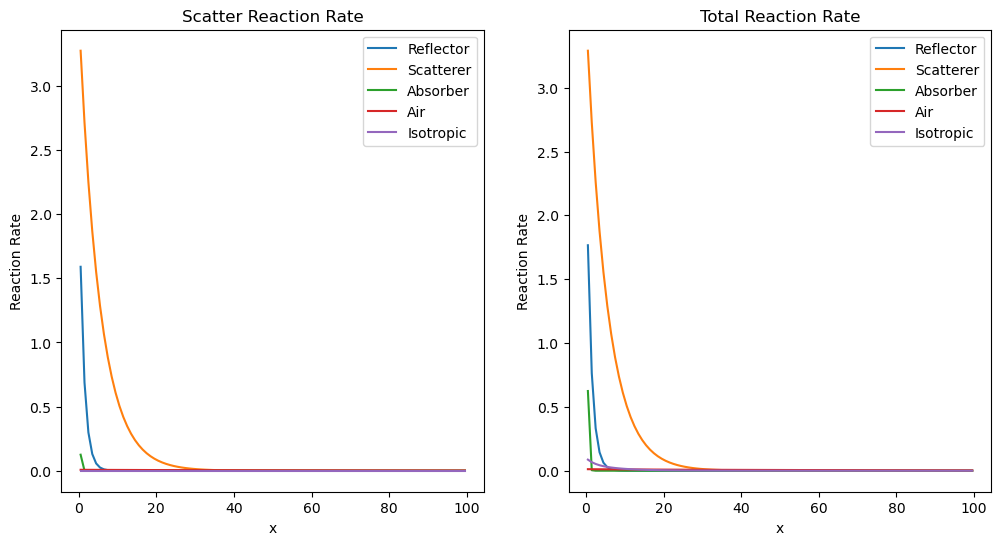

In [10]:
materials = {
    # Sigma t, Sigma s0, Q0
    "Reflector" : [2, 1.8, 0],
    "Scatterer" : [2, 1.99, 0],
    "Absorber" : [10, 2, 0],
    "Air" : [0.01, 0.006, 0],
    "Isotropic" : [0.1, 0, 1]
}

n_cells = 100
number_of_angles = 8
angles, weights = np.polynomial.legendre.leggauss(number_of_angles)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].set_title("Scatter Reaction Rate")
ax[1].set_title("Total Reaction Rate")


for material, properties in materials.items():
    solver = DiscreteOrdinates(
        angles=list(angles),
        weights=list(weights),
        left_boundary=1,
        right_boundary=0,
        volumetric_source=0,
        sigma_t=properties[0],
        sigma_s=properties[1],
        title_start=f"Test : {material}",
        x_end=100,
        n_surfaces=n_cells + 1,
    )
    scalar_flux = solver.angular_flux()

    ax[0].plot(solver.cell_x_pos, scalar_flux * properties[1], label=material)
    ax[1].plot(solver.cell_x_pos, scalar_flux * properties[0], label=material)

for a in ax:
    a.set_xlabel("x")
    a.set_ylabel("Reaction Rate")
    a.legend()

Test : Reflector: Converged after 146 iterations


C:\Users\bpeco\AppData\Local\Temp\ipykernel_23276\2170149106.py:31: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


Test : Scatterer: Converged after 2426 iterations
Test : Absorber: Converged after 10 iterations
Test : Air: Converged after 12 iterations
Test : Isotropic: Converged after 1 iterations


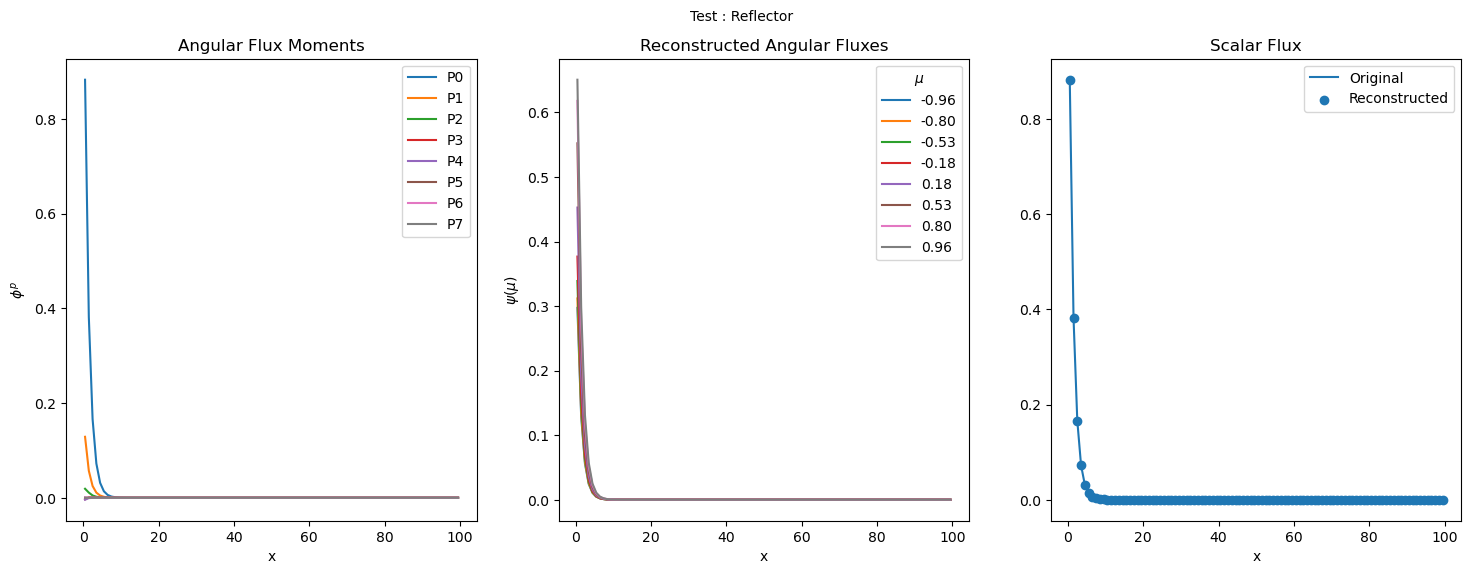

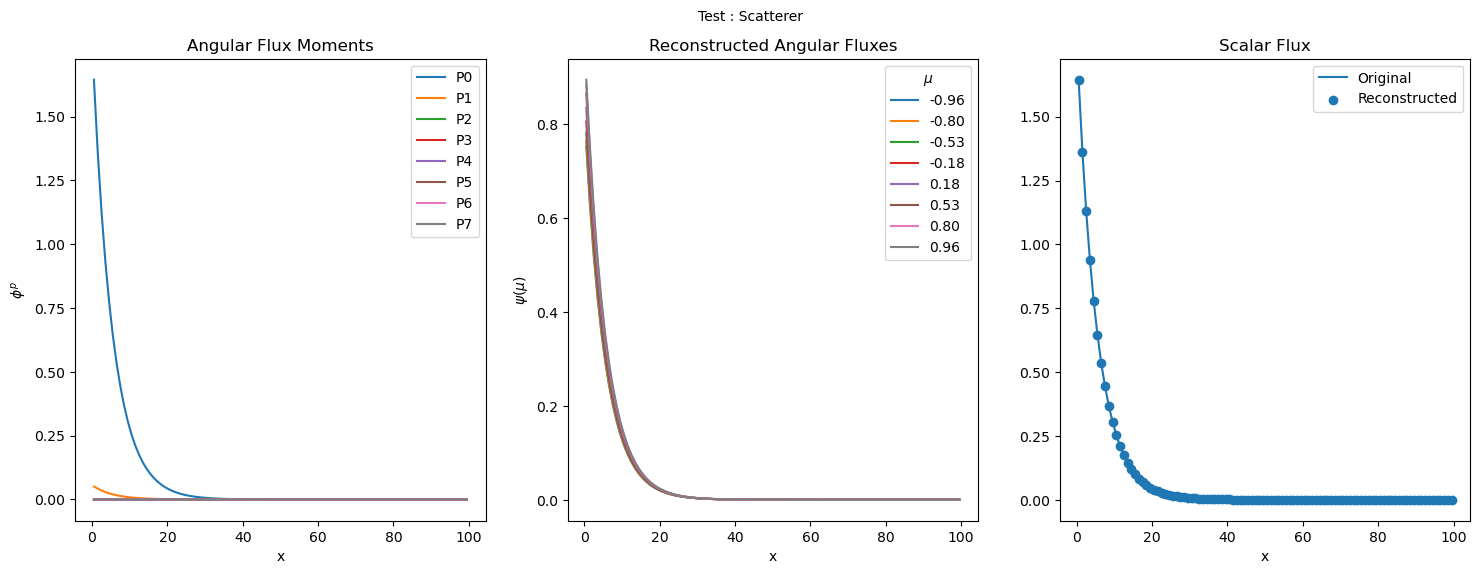

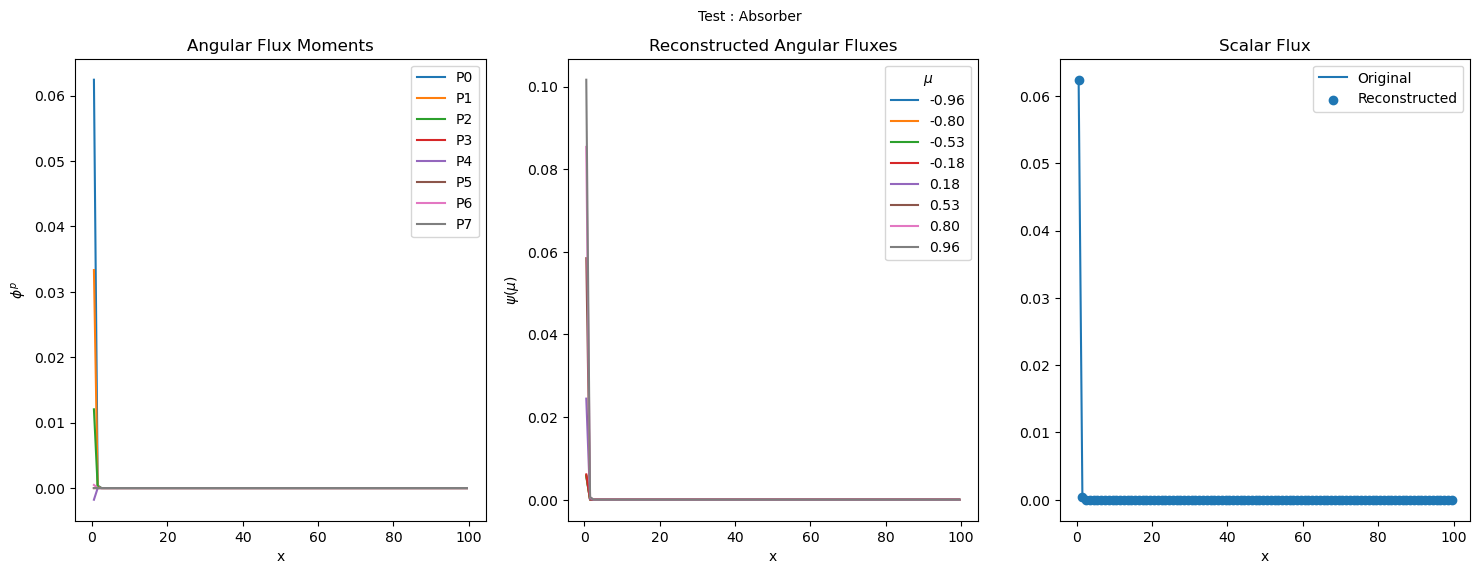

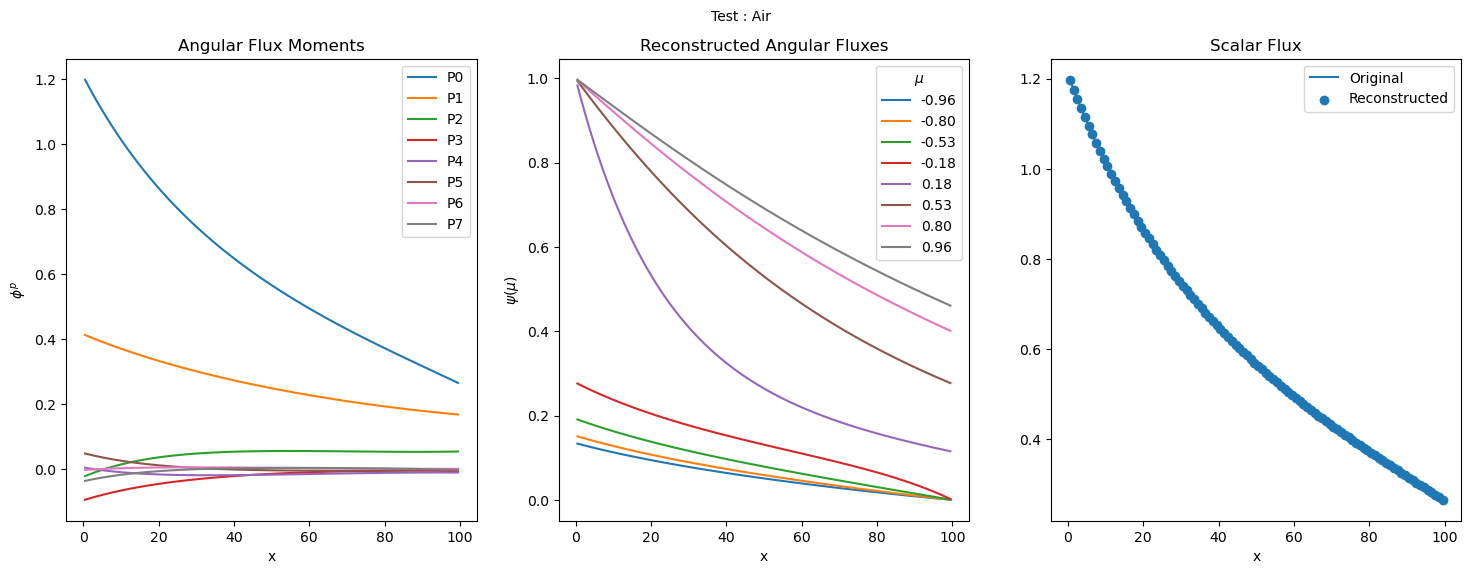

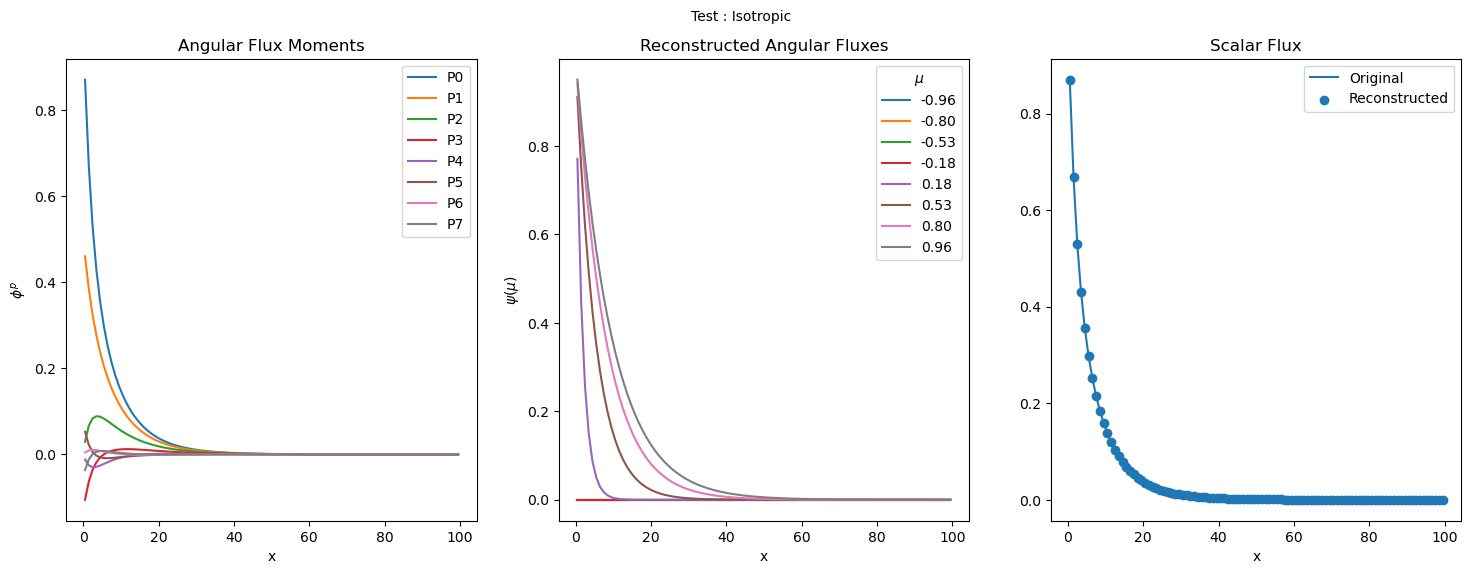

In [40]:
materials = {
    # Sigma t, Sigma s0, Q0
    "Reflector": [2, 1.8, 0],
    "Scatterer": [2, 1.99, 0],
    "Absorber": [10, 2, 0],
    "Air": [0.01, 0.006, 0],
    "Isotropic": [0.1, 0, 1],
}

n_cells = 100
number_of_angles = 8
angles, weights = np.polynomial.legendre.leggauss(number_of_angles)


for material, properties in materials.items():
    solver = DiscreteOrdinates(
        angles=list(angles),
        weights=list(weights),
        left_boundary=1,
        right_boundary=0,
        volumetric_source=0,
        sigma_t=properties[0],
        sigma_s=properties[1],
        title_start=f"Test : {material}",
        x_end=100,
        n_surfaces=n_cells + 1,
    )
    scalar_flux = solver.angular_flux()

    fig, ax = solver.angular_moments_plot()
    fig.show()

<>:33: SyntaxWarning: invalid escape sequence '\p'
<>:33: SyntaxWarning: invalid escape sequence '\p'
C:\Users\bpeco\AppData\Local\Temp\ipykernel_23276\2011867187.py:33: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel("$\phi^p$")
c:\Users\bpeco\miniconda3\Lib\site-packages\scipy\sparse\_index.py:155: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


$S_{64}$ Reflector: Converged after 0 iterations
$S_{64}$ Scatterer: Converged after 0 iterations
$S_{64}$ Absorber: Converged after 0 iterations
$S_{64}$ Air: Converged after 0 iterations
$S_{64}$ Isotropic: Converged after 1 iterations


Text(0.5, 0, 'x')

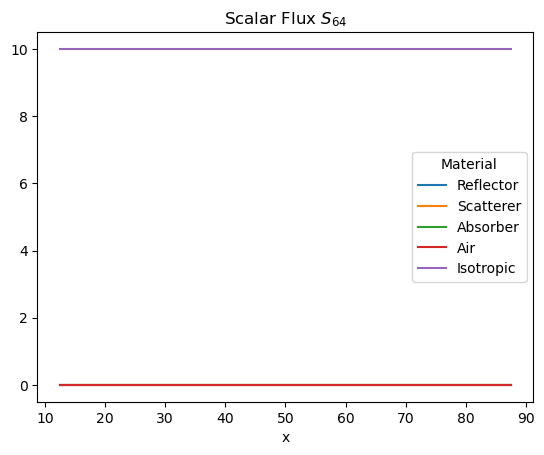

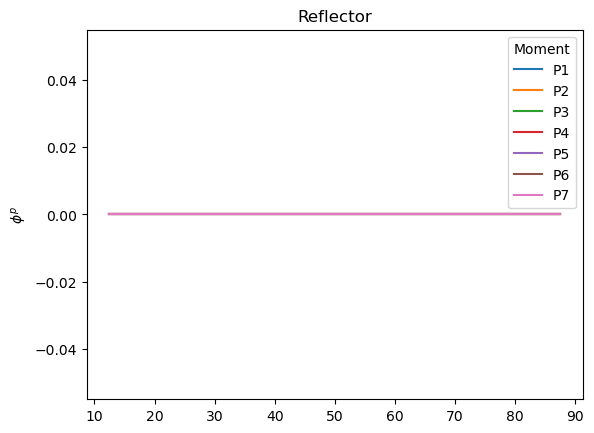

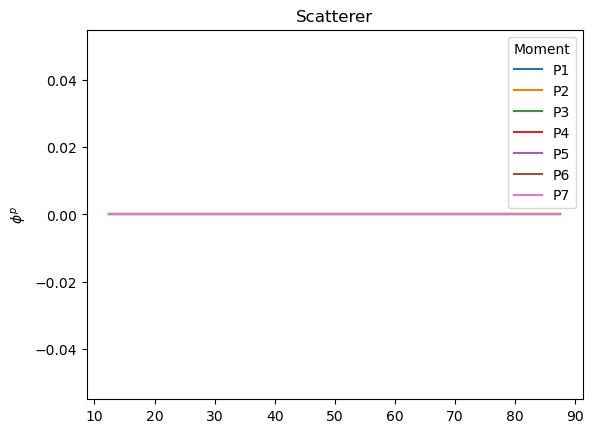

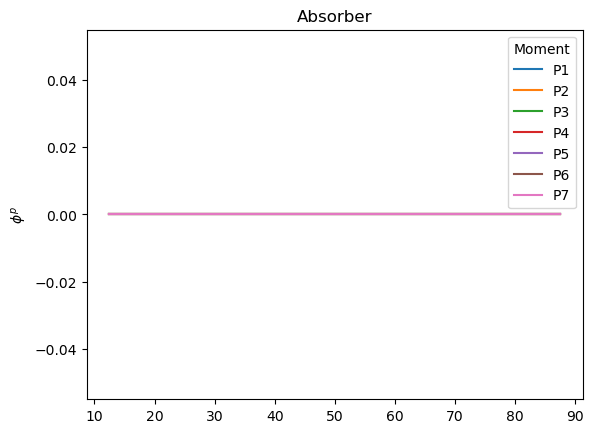

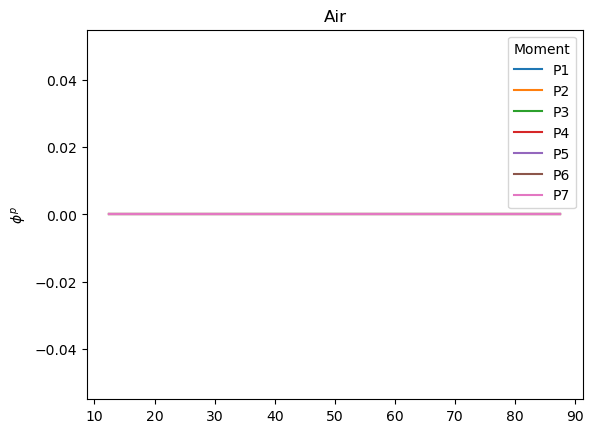

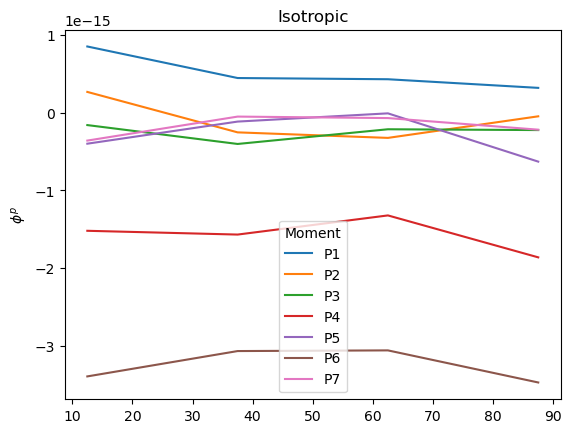

In [23]:
# Problem 1:

number_of_directions = 64
angles, weights = np.polynomial.legendre.leggauss(number_of_directions)

fig_all, ax_all = plt.subplots()

for material, properties in materials.items():
    solver = DiscreteOrdinates(
        angles=list(angles),
        weights=list(weights),
        left_boundary="reflecting",
        right_boundary="reflecting",
        volumetric_source=properties[2],
        sigma_t=properties[0],
        sigma_s=properties[1],
        title_start=f"$S_{{64}}$ {material}",
        x_end=100,
        n_surfaces= 5
    )
    scalar_flux_at_cells = solver.angular_flux()
    ax_all.plot(solver.cell_x_pos, scalar_flux_at_cells, label=material)
    
    moments, _ = solver.angular_moments()
    
    fig, ax = plt.subplots()
    for moment, angular_flux in moments.items():
        if moment == 0:
            continue
        ax.plot(solver.cell_x_pos, angular_flux, label=f"P{moment}")
    ax.legend(title="Moment")
    ax.set_title(material)
    ax.set_ylabel("$\phi^p$")

ax_all.legend(title="Material")
ax_all.set_title("Scalar Flux $S_{{64}}$")
ax_all.set_xlabel("x")

2: A: Converged after 8 iterations
A: 0.5036535897149073
A: 0.5649497144395026
2: B: Converged after 25 iterations
B: 0.6741324629211655
B: 0.49252567476687864
2: C: Converged after 147 iterations
C: 1.1658277147567517
C: 0.29795748597449356
2: D: Converged after 1287 iterations
D: 1.6661489645514216
D: 0.11550441143928367
2: E: Converged after 11102 iterations
E: 1.975453284171461
E: 0.0


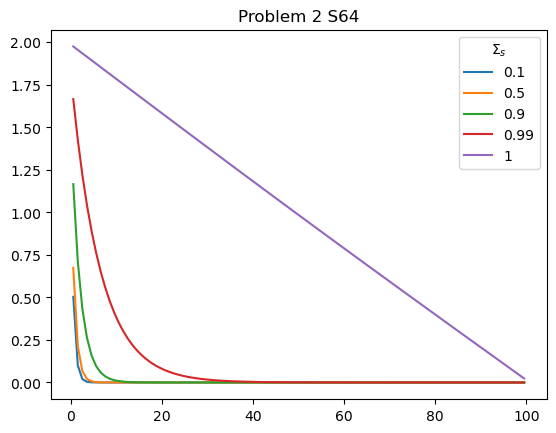

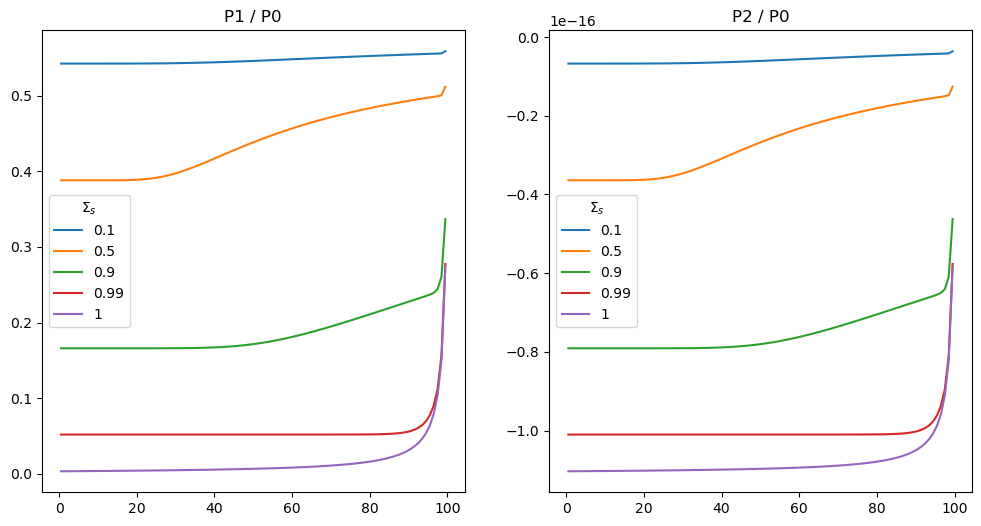

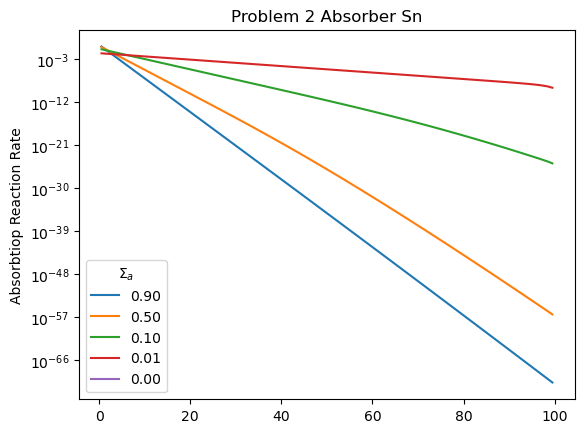

In [48]:
# Problem 2 make sure it works with different sigma scatters
number_of_directions = 2
angles, weights = np.polynomial.legendre.leggauss(number_of_directions)
n_cells = 100
materials = {
    # Sigma t, Sigma s0, Q0
    "Reflector": [2, 1.8, 0],
    "Scatterer": [2, 1.99, 0],
    "Absorber": [10, 2, 0],
    # "Air": [0.01, 0.006, 0], # does not converge
    # "Isotropic": [0.1, 0, 1],
}
materials = {
    "A" : [1, 0.1, 0],
    "B" : [1, 0.5, 0],
    "C" : [1, 0.9, 0],
    "D" : [1, 0.99, 0],
    "E" : [1, 1, 0],
}
fig, ax = plt.subplots()
fig_ratios, ax_ratios = plt.subplots(1, 2, figsize=(12, 6))
fig_absorber, ax_absorber = plt.subplots()
for material, properties in materials.items():
    solver = DiscreteOrdinates(
        angles=list(angles),
        weights=weights,
        left_boundary=1,
        right_boundary=0,
        volumetric_source=properties[2],
        sigma_t=properties[0],
        sigma_s=properties[1],
        title_start=f"2: {material}",
        x_end=100,
        n_surfaces=n_cells + 1
    )
    flux = solver.angular_flux();
    print(f"{material}: {flux[0]}")
    # solver.plot();
    ax.plot(solver.cell_x_pos, flux, label=properties[1])
    
    moments = solver.angular_moments()[0]
    p0 = moments[0]
    p1 = moments[1]
    p2 = moments[2]
    
    ax_ratios[0].plot(solver.cell_x_pos, p1 / p0, label=properties[1])
    ax_ratios[1].plot(solver.cell_x_pos, p2 / p0, label=properties[1])
    
    # f, a = solver.angular_moments_plot()
    # f.show()
    abs_cross_section = properties[0] - properties[1]
    ax_absorber.plot(solver.cell_x_pos, flux * abs_cross_section, label=f"{abs_cross_section:.2f}")
    print(f"{material}: {sum(flux * abs_cross_section)}")
    
ax.legend(title=r"$\Sigma_s$")
ax.title.set_text("Problem 2 S64")

ax_ratios[0].legend(title=r"$\Sigma_s$")
ax_ratios[0].title.set_text("P1 / P0")
ax_ratios[1].legend(title=r"$\Sigma_s$")
ax_ratios[1].title.set_text("P2 / P0")

ax_absorber.legend(title=r"$\Sigma_a$")
ax_absorber.set_ylabel("Absorbtiop Reaction Rate")
ax_absorber.title.set_text("Problem 2 Absorber Sn")
ax_absorber.set_yscale("log")

test3: Converged after 5 iterations
test3: Converged after 16 iterations
test3: Converged after 88 iterations
test3: Converged after 681 iterations
test3: Converged after 9434 iterations


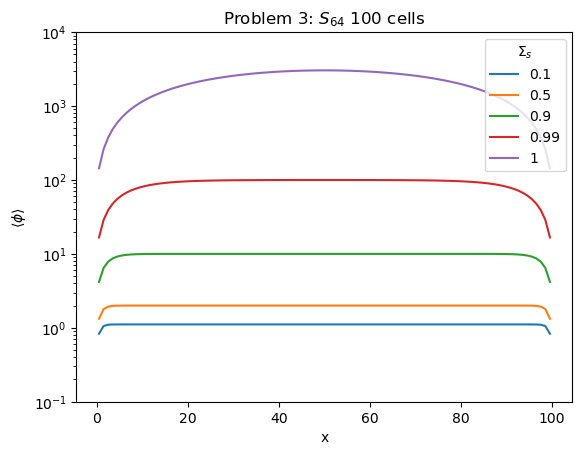

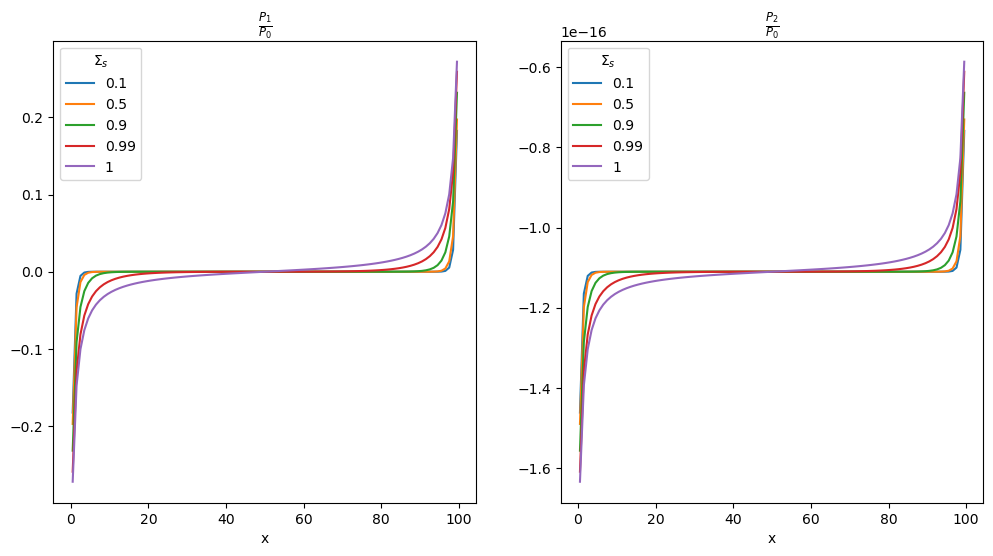

In [52]:
# Problem 3
n_cells = 100
number_of_directions = 64
angles, weights = np.polynomial.legendre.leggauss(2)
materials = {
    "A": [1, 0.1, 0],
    "B": [1, 0.5, 0],
    "C": [1, 0.9, 0],
    "D": [1, 0.99, 0],
    "E": [1, 1, 0],
}

fig, ax = plt.subplots()
fig_ratios, ax_ratios = plt.subplots(1, 2, figsize=(12, 6))
for material, properties in materials.items():
    solver = DiscreteOrdinates(
        angles=list(angles),
        weights=list(weights),
        left_boundary=0,
        right_boundary=0,
        volumetric_source=1,
        sigma_t=1,
        sigma_s=properties[1],
        title_start="test3",
        x_end=100,
        n_surfaces=n_cells + 1
    )
    flux = solver.angular_flux();
    ax.plot(solver.cell_x_pos, flux, label=properties[1])
    
    moments = solver.angular_moments()[0]
    p0 = moments[0]
    p1 = moments[1]
    p2 = moments[2]
    
    ax_ratios[0].plot(solver.cell_x_pos, p1 / p0, label=properties[1])
    ax_ratios[1].plot(solver.cell_x_pos, p2 / p0, label=properties[1])
    

ax.legend(title = r"$\Sigma_s$");
ax.set_xlabel("x");
ax.set_ylabel(r"$\langle \phi \rangle$");
ax.set_yscale("log");
ax.set_title(f"Problem 3: $S_{{{number_of_directions}}}$ {n_cells} cells");
ax.set_ylim(1e-1, 1e4)

ax_ratios[0].legend(title = r"$\Sigma_s$");
ax_ratios[0].set_xlabel("x");
ax_ratios[0].set_title(r"$\frac{P_1}{P_0}$");

ax_ratios[1].legend(title = r"$\Sigma_s$");
ax_ratios[1].set_xlabel("x");
ax_ratios[1].set_title(r"$\frac{P_2}{P_0}$");



<>:48: SyntaxWarning: invalid escape sequence '\S'
<>:53: SyntaxWarning: invalid escape sequence '\S'
<>:48: SyntaxWarning: invalid escape sequence '\S'
<>:53: SyntaxWarning: invalid escape sequence '\S'
C:\Users\bpeco\AppData\Local\Temp\ipykernel_29400\229081490.py:48: SyntaxWarning: invalid escape sequence '\S'
  ax.legend(title="$\Sigma_s$");
C:\Users\bpeco\AppData\Local\Temp\ipykernel_29400\229081490.py:53: SyntaxWarning: invalid escape sequence '\S'
  ax_error.legend(title="$\Sigma_s$");


3: 0: Converged after 1 iterations
3: 2 0: Converged after 1 iterations
3: 4 0: Converged after 1 iterations
3: 8 0: Converged after 1 iterations
3: 16 0: Converged after 1 iterations
3: 32 0: Converged after 1 iterations
3: 0.0001: Converged after 2 iterations
3: 2 0.0001: Converged after 2 iterations
3: 4 0.0001: Converged after 2 iterations
3: 8 0.0001: Converged after 2 iterations
3: 16 0.0001: Converged after 2 iterations
3: 32 0.0001: Converged after 2 iterations
3: 0.001: Converged after 2 iterations
3: 2 0.001: Converged after 2 iterations
3: 4 0.001: Converged after 2 iterations
3: 8 0.001: Converged after 2 iterations
3: 16 0.001: Converged after 2 iterations
3: 32 0.001: Converged after 2 iterations
3: 0.01: Converged after 3 iterations
3: 2 0.01: Converged after 3 iterations
3: 4 0.01: Converged after 3 iterations
3: 8 0.01: Converged after 3 iterations
3: 16 0.01: Converged after 3 iterations
3: 32 0.01: Converged after 3 iterations
3: 0.1: Converged after 5 iterations
3: 

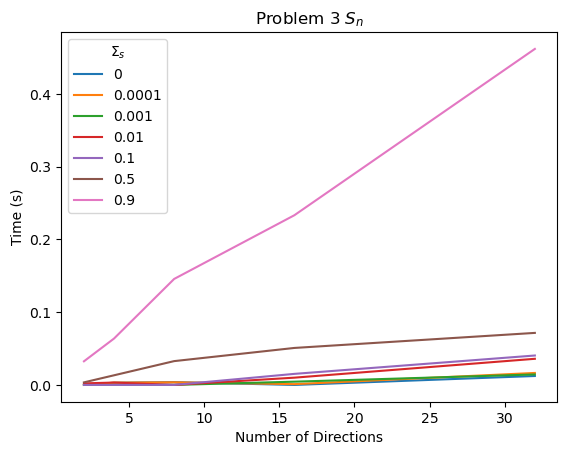

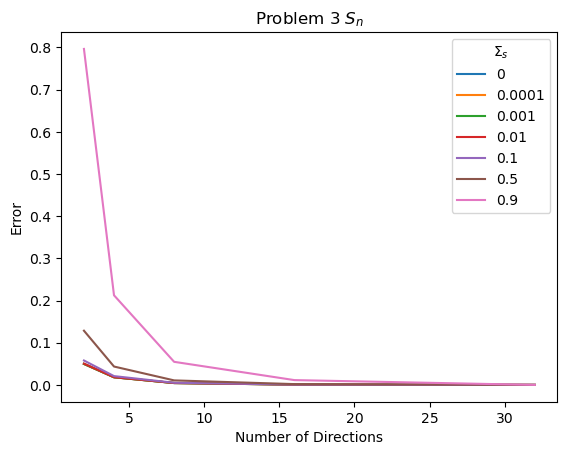

In [91]:
# Problem 3 testing directions
number_of_cells = 160
number_of_directions = [2, 4, 8, 16, 32]
sigma_scatters = [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 0.9]

fig, ax = plt.subplots()
fig_error, ax_error = plt.subplots()

for sigma_scatter in sigma_scatters:
    solution_times = []
    errors = []
    
    angles, weights = np.polynomial.legendre.leggauss(32)
    truth_solver = DiscreteOrdinates(
        angles=list(angles),
        weights=weights,
        left_boundary=0,
        right_boundary=0,
        volumetric_source=1,
        sigma_t=1,
        sigma_s=sigma_scatter,
        title_start=f"3: {sigma_scatter}",
        x_end=100,
        n_surfaces=number_of_cells + 1
    )
    truth_flux = truth_solver.angular_flux()
    for number_of_direction in number_of_directions:
        angles, weights = np.polynomial.legendre.leggauss(number_of_direction)
        solver = DiscreteOrdinates(
            angles=list(angles),
            weights=weights,
            left_boundary=0,
            right_boundary=0,
            volumetric_source=1,
            sigma_t=1,
            sigma_s=sigma_scatter,
            title_start=f"3: {number_of_direction} {sigma_scatter}",
            x_end=100,
            n_surfaces=number_of_cells + 1
        )
        angular_flux = solver.angular_flux()
        solution_times.append(solver.solver_time)
        errors.append(np.linalg.norm(truth_flux - angular_flux))

    ax.plot(number_of_directions, solution_times, label=sigma_scatter)
    ax_error.plot(number_of_directions, errors, label=sigma_scatter)
    
ax.legend(title="$\Sigma_s$");
ax.set_xlabel("Number of Directions");
ax.set_ylabel("Time (s)");
ax.set_title("Problem 3 $S_n$");

ax_error.legend(title="$\Sigma_s$");
ax_error.set_xlabel("Number of Directions");
ax_error.set_ylabel("Error");
ax_error.set_title("Problem 3 $S_n$");

In [ ]:
# Problem 3 testing resolution
number_of_cells = [10, 40, 160, 640, 2560, 10240]
number_of_directions = [2, 4, 8, 16, 32, 64]
time_limit = 30  # seconds
# sigma_scatters = [0, 0.0001, 0.001, 0.01, 0.1, 0.5, 0.9, 0.99, 0.999, 0.9999, 1]

# for sigma_scatter in sigma_scatters:
#     time_dict = {n_cell: {} for n_cell in number_of_cells}
    

#     for n_cells in number_of_cells:
#         for n_directions in number_of_directions:
#             angles, weights = np.polynomial.legendre.leggauss(n_directions)
#             solver = DiscreteOrdinates(
#                 angles=list(angles),
#                 weights=list(weights),
#                 left_boundary=0,
#                 right_boundary=0,
#                 volumetric_source=0,
#                 sigma_t=1,
#                 sigma_s=sigma_scatter,
#                 title_start=f"n={n_cells}, S_n={n_directions}",
#                 x_end=100,
#                 n_surfaces=n_cells + 1,
#             )

#             def time_solver():
#                 start = time.time()
#                 solver.angular_flux()
#                 end = time.time()
#                 return end - start

#             # this just sets a timelimit
#             # I don't want to run in parallel because memory is the main issue
#             with concurrent.futures.ThreadPoolExecutor(max_workers=1) as executor:
#                 future = executor.submit(time_solver)
#                 try:
#                     time_dict[n_cells][n_directions] = future.result(timeout=time_limit)
#                 except concurrent.futures.TimeoutError:
#                     time_dict[n_cells][n_directions] = f"Timeout: {time_limit}s"
#                     break
#                 except:
#                     time_dict[n_cells][n_directions] = "Error"
#                     break

#     time_df3 = pd.DataFrame(time_dict).T
#     time_df3.to_csv(f"time3_sigmas{sigma_scatter}.csv")

n=10, S_n=2: Converged after 1 iterations
n=10, S_n=4: Converged after 1 iterations
n=10, S_n=8: Converged after 1 iterations
n=10, S_n=16: Converged after 1 iterations
n=10, S_n=32: Converged after 1 iterations
n=10, S_n=64: Converged after 1 iterations
n=40, S_n=2: Converged after 1 iterations
n=40, S_n=4: Converged after 1 iterations
n=40, S_n=8: Converged after 1 iterations
n=40, S_n=16: Converged after 1 iterations
n=40, S_n=32: Converged after 1 iterations
n=40, S_n=64: Converged after 1 iterations
n=160, S_n=2: Converged after 1 iterations
n=160, S_n=4: Converged after 1 iterations
n=160, S_n=8: Converged after 1 iterations
n=160, S_n=16: Converged after 1 iterations
n=160, S_n=32: Converged after 1 iterations
n=160, S_n=64: Converged after 1 iterations
n=640, S_n=2: Converged after 1 iterations
n=640, S_n=4: Converged after 1 iterations
n=640, S_n=8: Converged after 1 iterations
n=640, S_n=16: Converged after 1 iterations
n=640, S_n=32: Converged after 1 iterations
n=640, S_n=6